In [1]:
%pylab inline

%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import GraphConvNet as gcn

import pickle as pk
import os
from glob import glob
from keras.utils import to_categorical

/home/nima/tensorflow/tf_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/nima/tensorflow/tf_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/nima/tensorflow/tf_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/nima/tensorflow/tf_gpu/lib/python3.6/site-packages/tensorf

# Making the Graph Datasets

In [4]:
import networkx as nx

def make_BA_dataset(N,n,m=2):
    adj = np.empty((N,n,n), dtype=np.float32)
    for j in range(N):
        g = nx.barabasi_albert_graph(n=n,m=m)
        a = zeros((n,n), dtype=np.float32)
        for i in g.edges:
            a[i] = 1
            a[i[::-1]] = 1
        adj[j] = a
    return adj

def make_ER_dataset(N,n,p=0.1):
    adj = np.empty((N,n,n), dtype=np.float32)
    for j in range(N):
        g = nx.erdos_renyi_graph(n=n, p=p)
        a = zeros((n,n), dtype=np.float32)
        for i in g.edges:
            a[i] = 1
            a[i[::-1]] = 1
        adj[j] = a
    return adj
    
        
def mat_pow_batch(A,n):
    """batch matrix power"""
    if n ==0:
        return np.float32([np.eye(A.shape[1])])
    M = A
    for _ in range(n-1):
        M = tf.matmul(A, M)
    return M.eval()
            

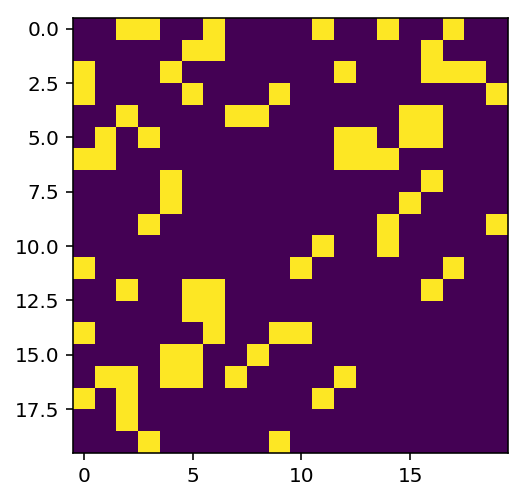

In [5]:
# X = make_BA_dataset(1000, 20)
X = make_ER_dataset(10, 20, p = .2)
imshow(X[0])

# Make large, mixed dataset
make a dataset of BA and ER mixed, with different densities

In [6]:
class Graph_dataset():
    def __init__(self,n_nodes = 20, num_samples = int(2e3), num_graph_densities = 1, max_moment_order = 3,
                 min_BA_density = 1, min_ER_density = 'auto' , max_BA_density = 0.5, max_ER_density = 0.5 ):
        
        self.label_classes = ['BA', 'ER']
        if min_ER_density == 'auto':
            min_ER_density = 1./n_nodes
        
        self._num_in_group = num_samples//(2*num_graph_densities)
        
        self.graph_params = {'BA' : int0(linspace(1, n_nodes* max_BA_density, num_graph_densities)),
                  'ER' : linspace(min_ER_density, max_ER_density, num_graph_densities)}

        self.Adj = {'BA' : concatenate([make_BA_dataset(self._num_in_group, n_nodes, m) for m in self.graph_params['BA']], axis = 0),
                   'ER' : concatenate([make_ER_dataset(self._num_in_group, n_nodes, p) for p in self.graph_params['ER']], axis = 0)}

        self.Adj_all = concatenate((self.Adj['BA'], self.Adj['ER']), axis = 0)
        self.get_label_parameter()
        self.get_graph_moments(n=max_moment_order)
        self.h = np.ones_like(self.moments[1])

    def get_label_parameter(self):
        self.full_labels = []
        for i,k in enumerate(self.label_classes):
            for p in self.graph_params[k]:
                self.full_labels += [[i,p]]*self._num_in_group

    def get_rand_indices(self,):
        self.rand_indices = np.argsort(np.random.rand(len(self.Adj_all)))

    def get_graph_moments(self, n= 3):
        self.moments = {1:self.Adj_all.sum(-1, keepdims=1)}
        for i in range(2,n+1):
            A = gcn.mat_pow_batch(self.Adj_all,i)
            self.moments[i] = A.sum(-1, keepdims=1) 
    
def shuffle_node_order(X):
    Adj_nodes_shuffled = np.empty_like(X)
    for i,a in enumerate(X):
        # get random order
        r = argsort(rand(len(a)))
        Adj_nodes_shuffled[i] = a[r][:,r]
    return Adj_nodes_shuffled

## Configuration model by shuffling outgoing stubs
The "Configuration Model" is a redistribution of edges (links) among the ndoes.
We do so trying to preserve the degree sequence, meaning the total number of edges assigned to each node.
On eway to do so is to build the "incidence matrix", $C$ which is a matrix from nodes to edges. 
If edge $e_1$ goes from node $n_1$ to $n_2$, the matrix entries  $C(n_1,e_1) = -1$ and $C(n_2,e_1)=1$. 
To get a configuration model from a graph, we simply need to shuffle the end point assignments in $C$, meaning that we keep the number of nn-zero elements fixed but shuffle the columns for $-1$ and $1$ entries such that every column has again one $-1$ and one $1$ entry. In practice, an arbitrary shuffle may not assign end-points to all edges, so the final number of dges in the graph may be less than the original. 
To prevent the GCN from exploiting number of links, we trim down the original graph by removing links randomly to make it have the same number of edges as the Config. model. 

The networkx package has an implementation of config. model, but we also implemented our own version below. 

In [7]:
def get_incidence(a):
    """make incidence matrix from adjacency matrix"""
    ix = np.where(np.triu(a))
    edg = array(list(zip(*ix)))
    incid = np.zeros((len(a), len(edg)), dtype=np.float32)
    for _,[i,j] in enumerate(edg): 
        incid[i,_] = 1
        incid[j,_] = -1
    return incid

def incidence_shuffle(incid):
    neg = np.where(incid < 0)
    # preserve the rows, to preserve node degree, but shuffle columns, to shuffle links
    np.random.shuffle(neg[1])
    incid2 = 1.* (incid> 0 )
    incid2[neg] -= 1
    return incid2

def configuration_model_1(a, weighted = True):
    incid = get_incidence(a)
    incid2 = incidence_shuffle(incid)
    lap = incid2.dot(incid2.T)
    deg = lap.diagonal() 
    a2 = np.diag(deg)-lap
    if not weighted:
        a2 = (1*(a2>0))
    return a2

# def make_data_config_model(X, weighted = True, shuffle_networks = False, shuffle_nodes = False):
#     print(('Not s' if not shuffle else 'S')+'huffling order')
#     dat = np.array([configuration_model_1(a, weighted) for a in X])
#     dat = np.concatenate((X,dat))
#     print('labels: {0:"real", 1:"fake"}')
#     labels = np.zeros((2*len(X,)), dtype = np.float32)
#     labels[len(X):] = 1
#     if shuffle_networks:
#         idx = np.argsort(np.random.rand(2*len(X)))
#         dat = dat[idx]
#         labels = labels[idx]
#     if shuffle_nodes:
#         dat = shuffle_node_order(dat)
#     return dat, labels
    
def trim_mat(a,b):
    """remove random links from 'a' until it has the same number of links as 'b'"""
    i = (a.sum(0)!= b.sum(0))
    ms = i[:,np.newaxis]*i[np.newaxis]
    masked_a = a*np.triu(ms)
    ix = np.where(masked_a)
    # num missing links
    d = int(a.sum()-b.sum())//2
    # randomly choose r indices to knockout
    r = np.argsort(np.random.rand(len(ix[0])))[:d]
    # make trimmed graph
    c = triu(a) + 0.
    for i in r:
        c[ix[0][i],ix[1][i]]=0
    c += c.T 
    return c
    
def make_data_config_model(X, weighted = True, shuffle_networks = False, shuffle_nodes = False, trim_links = False):
    """ Create a Configuration Model ensemble from adjacency matrices in X (samples, N,N)
    returns concatenate([X,config model of X]) , labels ([0 for X and 1 for Config model])
    weighted: whether links in configuration model are allowed to be weighted 
        (leads to less discrepancy with X in total link weight)
    shuffle_networks: whether output order should be shuffled (default False)
        if False, the first half of the output are the original 
    shuffle_nodes: whether to shuffle node order (default False)
    trim_links: whether to randomly remove links in X so that is has 
        the same number of links the Config. Model X. 
    """
    print(('Not s' if not shuffle else 'S')+'huffling order')
    config = np.array([configuration_model_1(a, weighted) for a in X])
    if trim_links:
        print('trimming links')
        trimmed_X = np.array([trim_mat(a,b) for a,b in zip(X,config)])
        dat = np.concatenate((trimmed_X, config))
    else:
        dat = np.concatenate((X,config))
    print('labels: {0:"real", 1:"fake"}')
    labels = np.zeros((2*len(X,)), dtype = np.float32)
    labels[len(X):] = 1
    if shuffle_networks:
        idx = np.argsort(np.random.rand(2*len(X)))
        dat = dat[idx]
        labels = labels[idx]
    if shuffle_nodes:
        dat = shuffle_node_order(dat)
    return dat, labels

In [ ]:
n_list =  [10 ,15, 20, 30, 40,50, 60]
n = n_list[-3] 
data = Graph_dataset(n_nodes=n, num_samples= int(5e3), num_graph_densities=5)
data.get_rand_indices()

data.Adj_all.shape

In [415]:
data.graph_params

{'BA': array([ 1,  5, 10, 15, 20]),
 'ER': array([0.025  , 0.14375, 0.2625 , 0.38125, 0.5    ])}

# BA vs ER

In [249]:
data.label_classes

['BA', 'ER']

In [101]:
GRAPH_TYPE = 'BA_vs_ER'
EXP_DIR = '../experiments/gcn_classification_grid_2_no_flatten/'
os.makedirs(EXP_DIR, exist_ok=True)

RUN_FILE = './run_gcn_classification_v2.py'
TRIMMED = False



labels = to_categorical(array(data.full_labels)[:,0]) # first column is BA,ER, second col is parameter m or p 

dataset = {
    'Adj':data.Adj_all, 
    'labels':labels,
    'rand_indices':data.rand_indices 
}

dataset_path = EXP_DIR+'%s-N%d_config_dataset-%d'\
        %(GRAPH_TYPE,data.Adj_all.shape[1] ,len(data.Adj_all)) + ('-trimmed' if TRIMMED else'')+'.pkl'
print(dataset_path)
pk.dump(dataset,open(dataset_path,'wb'))


# SAVE_PATH = '../experiments/gcn_classification_grid/%s/' % GRAPH_TYPE
SAVE_PATH = EXP_DIR+'%s_leaky_relu' % GRAPH_TYPE + ('-trimmed' if TRIMMED else'')+ '/'
os.makedirs(SAVE_PATH, exist_ok=True)


../experiments/gcn_classification_grid_2_no_flatten/BA_vs_ER-N30_config_dataset-5000.pkl


In [87]:
data.Adj['BA'][-1].sum(), data.Adj['ER'][-1].sum()

(112.0, 102.0)

# Config Model Classification

Shuffling order
trimming links
labels: {0:"real", 1:"fake"}
../experiments/gcn_classification_grid_2_no_flatten/BA-N40_config_dataset-5000-trimmed.pkl


(0.0, 1.0)

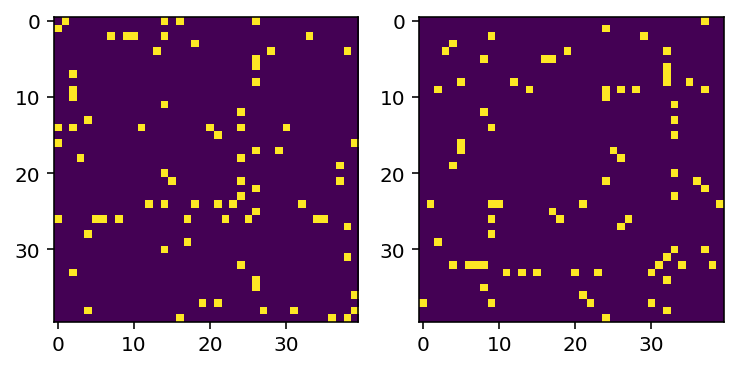

In [396]:

GRAPH_TYPE = 'BA' 
# GRAPH_TYPE = 'ER'

# EXP_DIR = '../experiments/gcn_classification_grid/'
# RUN_FILE = './run_gcn_classification_v1.py'

EXP_DIR = '../experiments/gcn_classification_grid_2_no_flatten/'
RUN_FILE = './run_gcn_classification_v2.py'

os.makedirs(EXP_DIR, exist_ok=True)

# TRIMMED: Config model may have less links than original graph; 
# TRIMMED=True reduces the links of the original to match Config model. 
TRIMMED = True
# TRIMMED = False
data_config, labels_config = make_data_config_model(data.Adj[GRAPH_TYPE], weighted=False, shuffle_nodes=True, trim_links=TRIMMED)

idx = argsort(rand(len(data_config)))
h = ones(data_config.shape[:2]+(1,))

dataset = {
    'Adj':data_config, 
    'labels':to_categorical(labels_config),
    'rand_indices':idx 
}

dataset_path = EXP_DIR+'%s-N%d_config_dataset-%d'\
        %(GRAPH_TYPE,data.Adj_all.shape[1] ,len(data_config)) + ('-trimmed' if TRIMMED else'')+'.pkl'
print(dataset_path)
pk.dump(dataset,open(dataset_path,'wb'))


# SAVE_PATH = '../experiments/gcn_classification_grid/%s/' % GRAPH_TYPE
SAVE_PATH = EXP_DIR+'%s_leaky_relu' % GRAPH_TYPE + ('-trimmed' if TRIMMED else'')+ '/'
os.makedirs(SAVE_PATH, exist_ok=True)


subplot(121)
imshow(data_config[0])
subplot(122)
imshow(data_config[len(data.Adj[GRAPH_TYPE])])
labels_config[0], labels_config[len(data.Adj[GRAPH_TYPE])]

In [163]:
l = len(data_config)
a = data_config[500]
b = data_config[500+l//2]
a.sum(), b.sum()

(602.0, 536.0)

# Run Experiments

In [397]:
import os 

EPOCHS = 400

ACT = {0: 'linear', 
       1: 'relu', 
       2: 'sigmoid',
       3: 'tanh',
      }

activation = ACT[0]

# units_per_layer = 2
# bias = True
skip = True

params = {
    'units': [], 
    'skip': skip, # whether to pass on skip layers to output
    'activation': activation, # used for all layers
#     'GCN_kws': {'use_bias': bias}, 
#     'dense_kws': {'use_bias': bias}, 
    'final_kws': {'units':10,}, #'activation': 'relu'}, 
    # linear activation is best for final layer
         }

print(RUN_FILE)
for n_layer in range(1,6):
    for units_per_layer in range(1,6,2):
        params['units'] = [units_per_layer] * n_layer
        os.system(RUN_FILE+''' %s "%s" %s %d &''' % ( dataset_path, params, SAVE_PATH , EPOCHS))


./run_gcn_classification_v2.py


# Config. Model vs Real 

In [351]:
b= a.shape[0] # number of bins
c = 100
dif_real = {} 
for i in range(0,len(data_config)//2,c):
    for j in range(i,len(data_config)//2,c):
        for order in range(1,6):
            m = matrix_power(data_config[i],order).sum(0)
            md = matrix_power(data_config[j],order).sum(0)
            
            mn,mx = min(m.min(),md.min()), max(m.max(), md.max())
            h, _ = histogram(m, b, range= (mn,mx), normed=True)
            hd, _ = histogram(md, b, range= (mn,mx), normed=True)
            dif_real[order] = dif_real.get(order,[]) + [abs(h.cumsum()-hd.cumsum()).max()]
        

In [355]:
b= a.shape[0] # number of bins
c = 100
dif_fake = {} 
for i in range(0,len(data_config)//2,c):
    for j in range(i+len(data_config)//2, len(data_config) ,c):
        for order in range(1,6):
            m = matrix_power(data_config[i],order).sum(0)
            md = matrix_power(data_config[j],order).sum(0)
            
            mn,mx = min(m.min(),md.min()), max(m.max(), md.max())
            h, _ = histogram(m, b, range= (mn,mx), normed=True)
            hd, _ = histogram(md, b, range= (mn,mx), normed=True)
            dif_fake[order] = dif_fake.get(order,[]) + [abs(h.cumsum()-hd.cumsum()).max()]
        

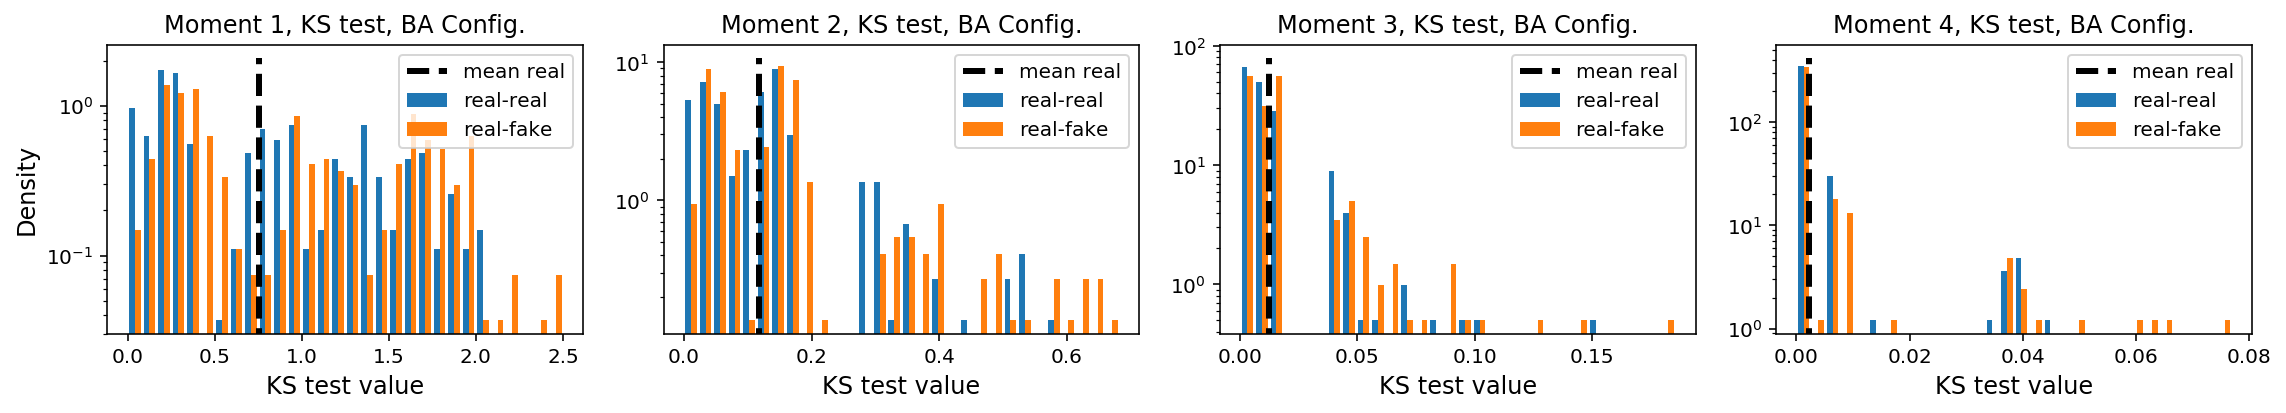

In [412]:
figure(figsize = (16,3))
for k in sorted(dif_real)[:-1]:
    subplot(1,4,k)
    [h,hd],bns,_ = hist([dif_real[k],dif_fake[k] ], b, label = ['real-real','real-fake'], log = 1, alpha = 1, density=True)
    title('Moment %d, KS test, BA Config.'%k)
    xlabel('KS test value',fontsize = 12)
    if k == 1:
        ylabel('Density',fontsize = 12)
    plot([mean(dif_real[k])]*2, [min(h), 1.2*max(h)], lw = 3 , c = 'k', ls = '--', label ='mean real')
    legend()
    tight_layout()
    
savefig('../figs/expressivity/GCN/configuration_model/gcn-config-KS-BA-1-row.pdf')
savefig('../figs/expressivity/GCN/configuration_model/gcn-config-KS-BA-1-row.png', dpi = 300)

In [325]:
i = 100
a = data_config[i+5]
ad = data_config[i] #+len(data_config)//2]

In [286]:
a.shape

(30, 30)

In [288]:
from scipy.stats import kstest
# In the end, we didn't use the kstest function and did the comparison manually by drawing the distribution of varios graph moments. 

In [289]:
m, md = moments[-1], moments_config[-1]

In [291]:
b = 20
h = histogram(m, b)
hd = histogram(md, b)

In [338]:
dif = []
b= 20
for i, (m, md) in enumerate(zip( moments, moments_config)):
    mn,mx = min(m.min(),md.min()), max(m.max(), md.max())
    h, _ = histogram(m, b, range= (mn,mx), normed=True)
    hd, _ = histogram(md, b, range= (mn,mx), normed=True)
#     [h,hd], bns, p = hist([m,md],20, density=1,)# cumulative=1);
#     show()
    #dif+= [[i+1,abs(h-hd).max()]]
    dif+= [[i+1,abs(h.cumsum()-hd.cumsum()).max()]]
#     plt.clf()

In [336]:
dif = [] 
for i, (m, md) in enumerate(zip( moments, moments_config)):
    [h,hd], bns, p = hist([m,md],20, density=1,)# cumulative=1);
#     show()
    #dif+= [[i+1,abs(h-hd).max()]]
    dif+= [[i+1,abs(h.cumsum()-hd.cumsum()).max()]]
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [334]:
a.shape[0]**(arange(1,6)/2)

array([   5.47722558,   30.        ,  164.31676725,  900.        ,
       4929.50301755])

Text(0, 0.5, 'KS difference')

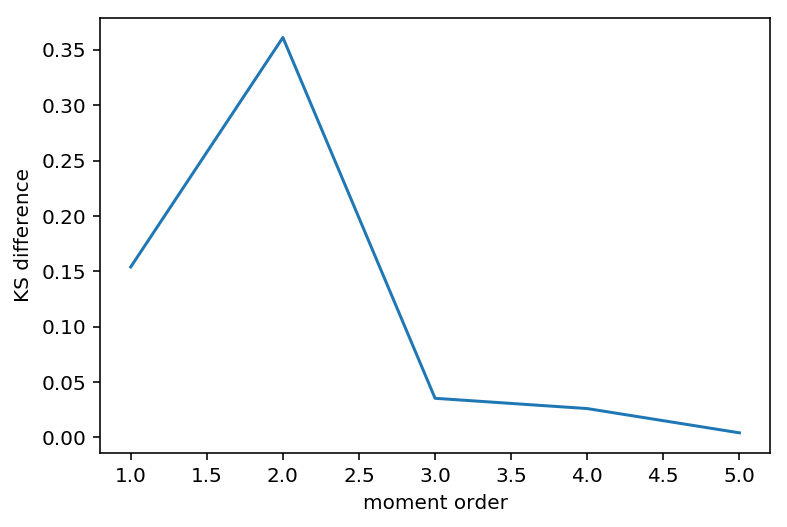

In [339]:
plot(*array(dif).T)
xlabel('moment order')
ylabel('KS difference')

In [340]:
dif

[[1, 0.15384615384615397],
 [2, 0.3611111111111111],
 [3, 0.035256410256410256],
 [4, 0.02597402597402597],
 [5, 0.004059829059829059]]

In [329]:
hd

array([0.00064103, 0.0025641 , 0.00277778, 0.00021368, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00021368])

In [312]:
abs(h-hd).max()

0.06666666666666668

In [313]:
abs(h.cumsum()-hd.cumsum()).max()

0.06666666666666687

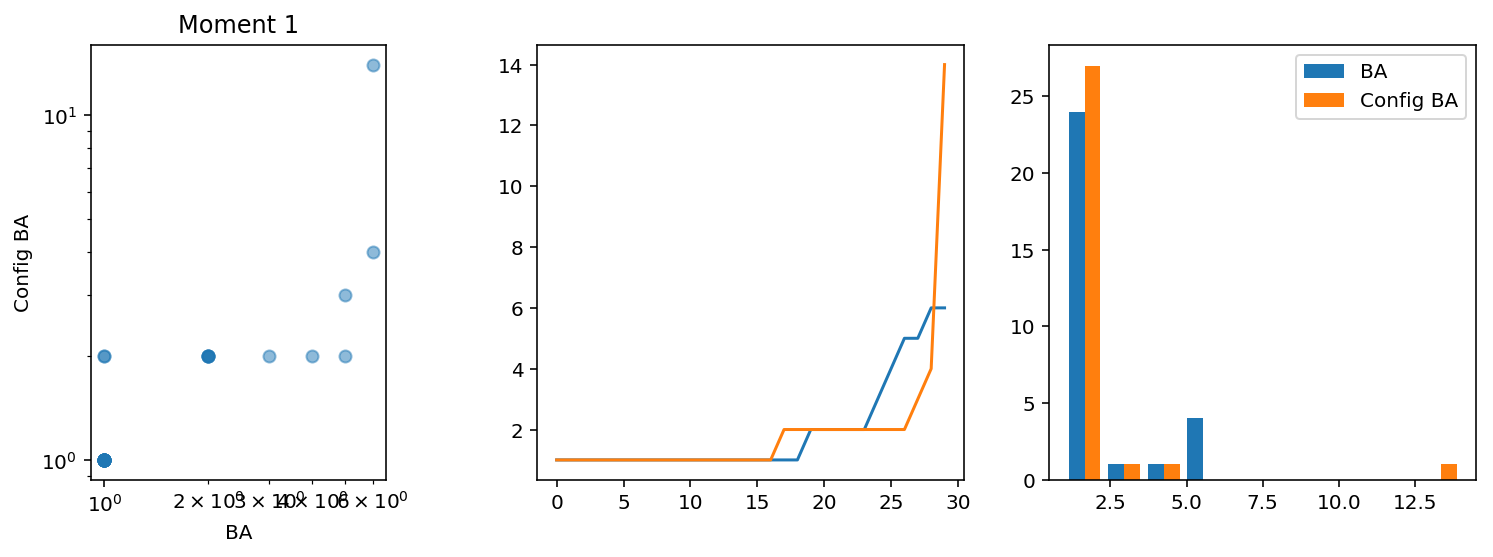

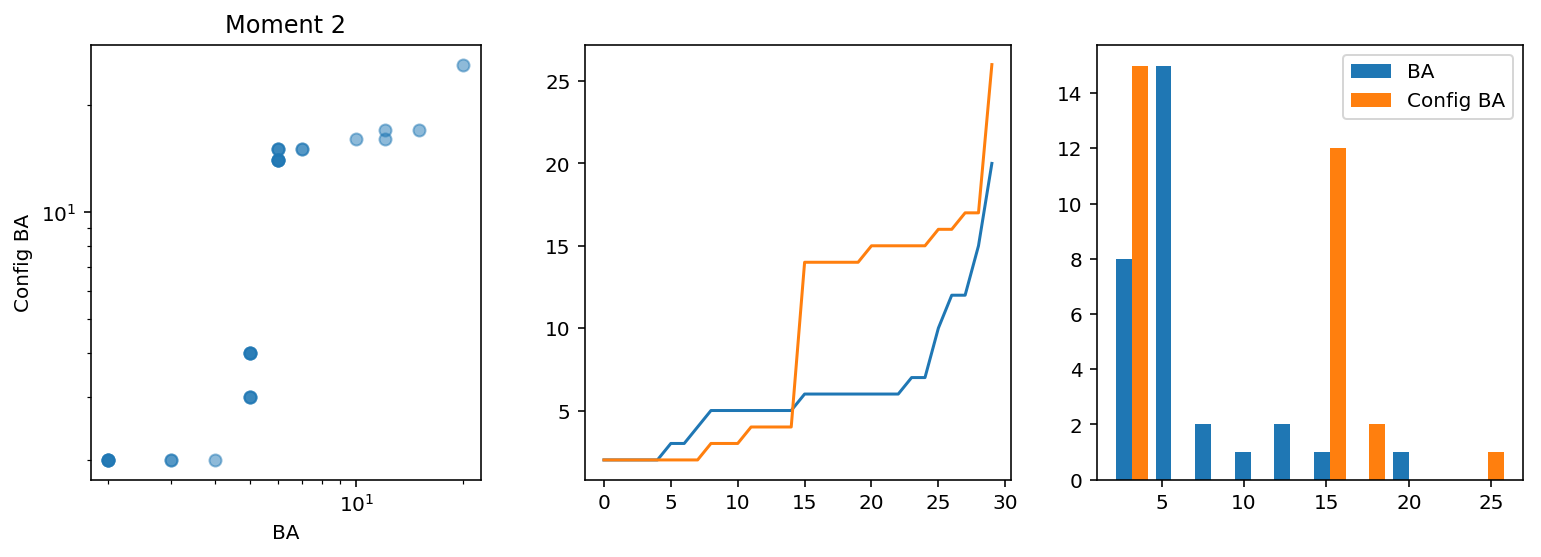

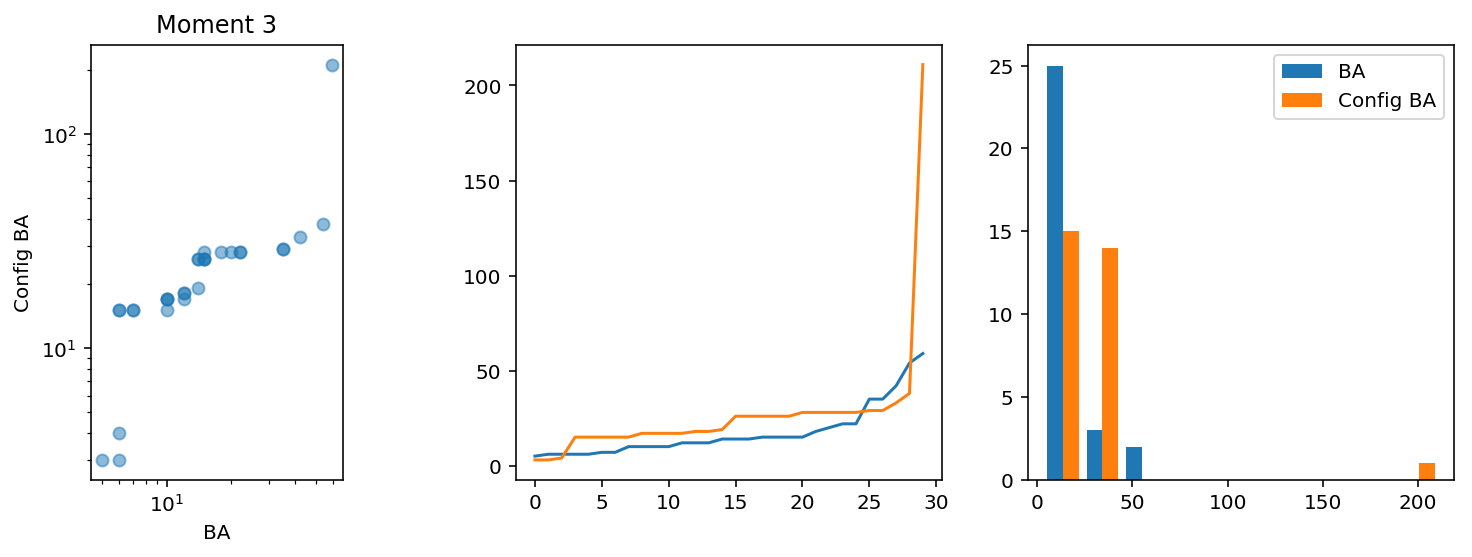

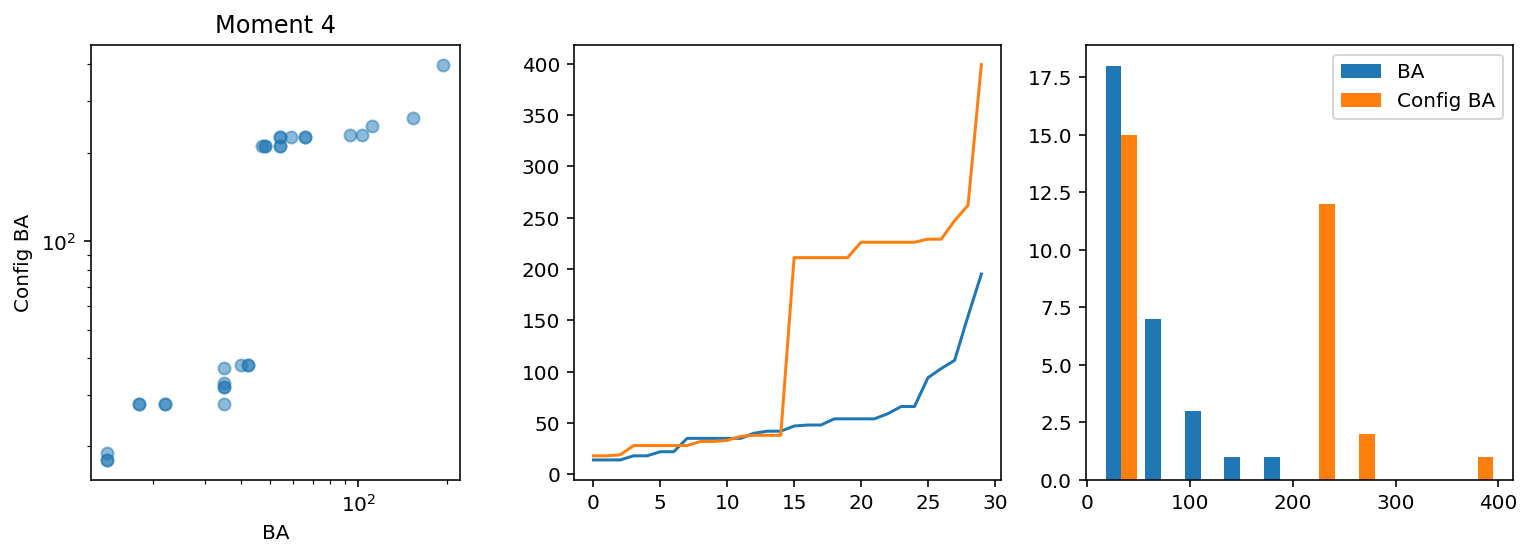

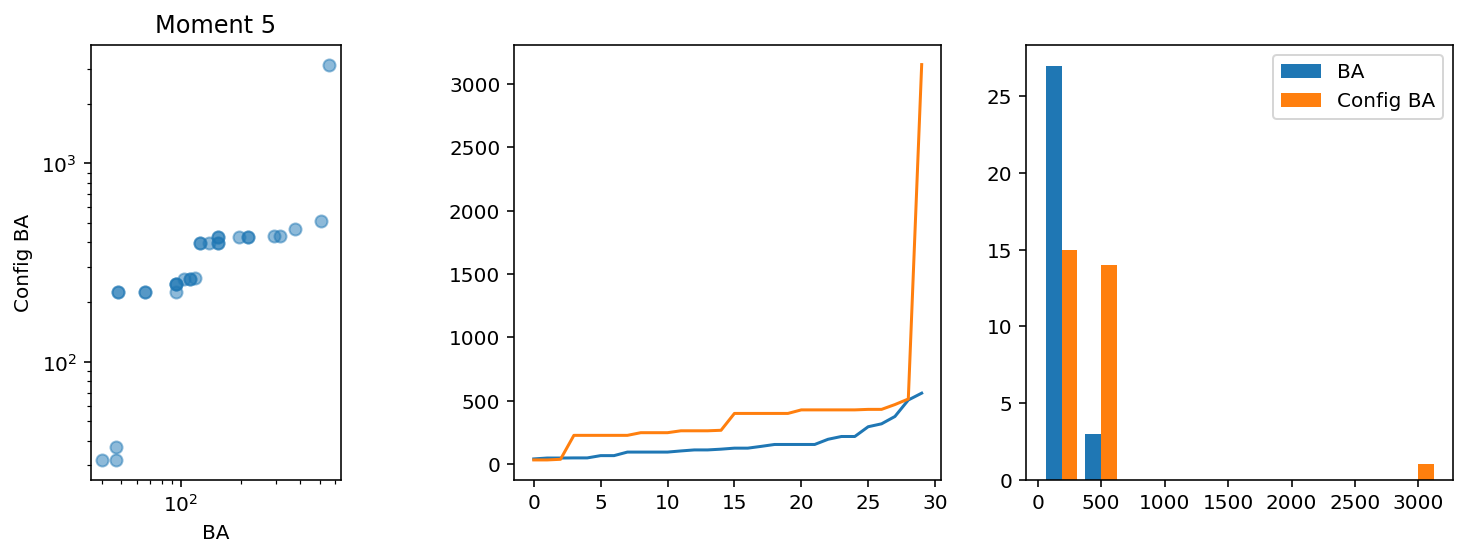

In [326]:
moments = []
moments_config = []
n = a.shape[0]
for i in range(1,6):
    moments += [matrix_power(a,i).sum(0)/ n**(0)]
    moments_config += [matrix_power(ad,i).sum(0)/ n**(0)]
    figure(figsize=(13,4))
    subplot(131, aspect = 1)
    plot(sorted(moments[-1]),sorted(moments_config[-1]), 'o', alpha = 0.5)
    title( 'Moment %d' %i)
    xlabel('BA')
    ylabel('Config BA')
    xscale('log')
    yscale('log')
    
    subplot(132)
    plot(sorted(moments[-1]),label='BA')
    plot(sorted(moments_config[-1]), label='Config BA')
    subplot(133)
    hist([moments[-1], moments_config[-1]],label=['BA','Config BA'])
    legend()
    show()
    

# Config. Model Classification results

In [85]:
# pth = SAVE_PATH
# pth = '../experiments/gcn_classification_grid_2_no_flatten/BA_vs_ER_leaky_relu/'
pth = '../experiments/gcn_classification_grid_2_no_flatten/BA_leaky_relu-trimmed/'
# pth = '../experiments/gcn_classification_grid_2_no_flatten/BA_leaky_relu/'

res = glob(pth + '/gcn*.pkl')
# res = glob( '../experiments/gcn_classification_grid_2_no_flatten/BA_leaky_relu/gcn*.pkl')

len(res), res[0]

(75,
 '../experiments/gcn_classification_grid_2_no_flatten/BA_leaky_relu-trimmed/gcn_model-N10-gcn[units[1, 1, 1, 1]-activation_linear]-final[units_10]-skip1.pkl')

'../experiments/gcn_classification_grid_2_no_flatten/BA_leaky_relu-trimmed/gcn_model-N10-gcn[units[1, 1, 1, 1]-activation_linear]-final[units_10]-skip1.pkl'

### Get list of node numbers

In [57]:
n_list = sorted(set(int(fname.split('-N')[1].split('-')[0]) for fname in res))
n_list

[10, 20, 30, 40, 50]

../figs/expressivity/GCN/configuration_model/gcn-1-BA_vs_ER_leaky_relu-All


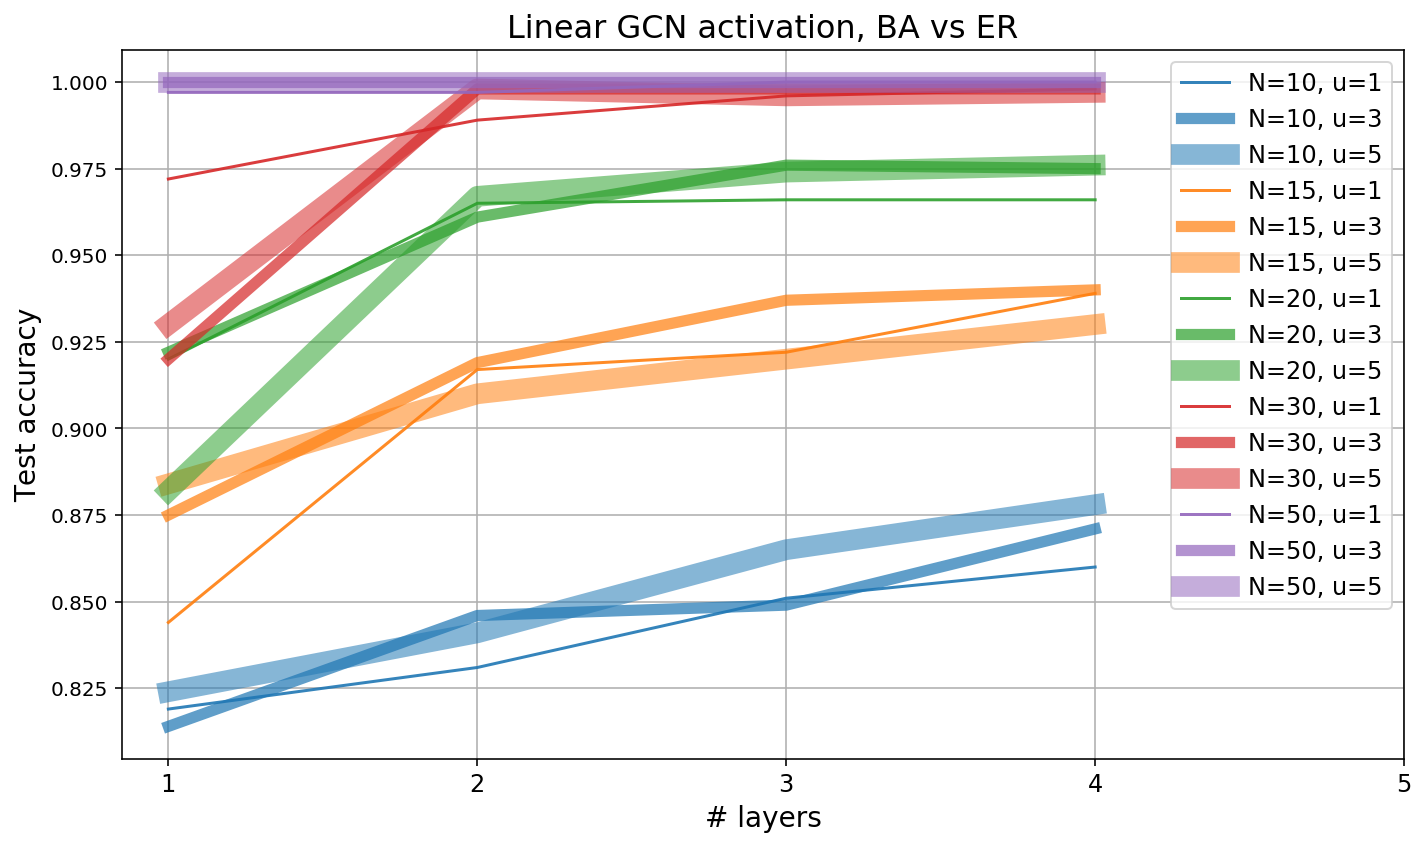

In [83]:
typ = pth.strip('/').split('/')[-1]
cols = dict(enumerate(mpl.colors.TABLEAU_COLORS))

# stl = ['-','--', ':']
figure(figsize=(10,6))
for ii,n in enumerate(n_list):
#     if n==40:continue
    results = {}
    for r in res:
        if int(r.split('-N')[1].split('-')[0]) != n:
            continue
    #     print(r)
        g = pk.load(open(r, 'rb'))
        
        n_lay = len(g['params']['units'])
        act = g['params']['activation']
        results.setdefault(act, {})
        u = g['params']['units'][0]
        results[act][u] = results[act].get(u,[]) +[[n_lay,max(g['history']['val_acc'])]]


    for a in results:
        r1 = results[a]
        results[a] = {k: array(results[a][k])[argsort(array(results[a][k])[:,0])] for k in results[a]}
        
    for a in results:
        r1 = results[a]
        for i1,k in enumerate(sorted(r1)):
            plot(*r1[k][:-1].T, label = 'N=%d, u=%d' %(n,k), #ls= stl[i1],#marker = '.',
                 lw=1.5*k**1.2 , alpha= 1-tanh(k/10), c= cols[ii])
        t = ('%s vs Configuration Model' %typ.split('_')[0] if '_vs_' not in typ else typ.strip('_leaky_relu').replace('_', ' '))
        title('%s GCN activation, %s' %(a.capitalize(), t) + (', pruned' if '-trimmed' in res[0] else ''), size=16 )
        xlabel('# layers', size = 14)
        ylabel('Test accuracy', size = 14)
        xticks(arange(1,6),fontsize=12)
#         if ylim()[0] >0.95:
#             ylim(0.95,1.01)
#         ylim(0.75,1.01)
#         legend(ncol=5)

legend(fontsize= 12)
grid()

tight_layout()

config_dir = '../figs/expressivity/GCN/configuration_model/' 

nam = config_dir+'gcn-1-%s-All'%(typ) + ('-trimmed' if '-trimmed' in res[0] else '')
print(nam)

# savefig(nam +'.pdf')
# savefig(nam +'.png', dpi=300)
        
#         show()


../figs/expressivity/GCN/configuration_model/gcn-1-BA_leaky_relu-trimmed-All-trimmed


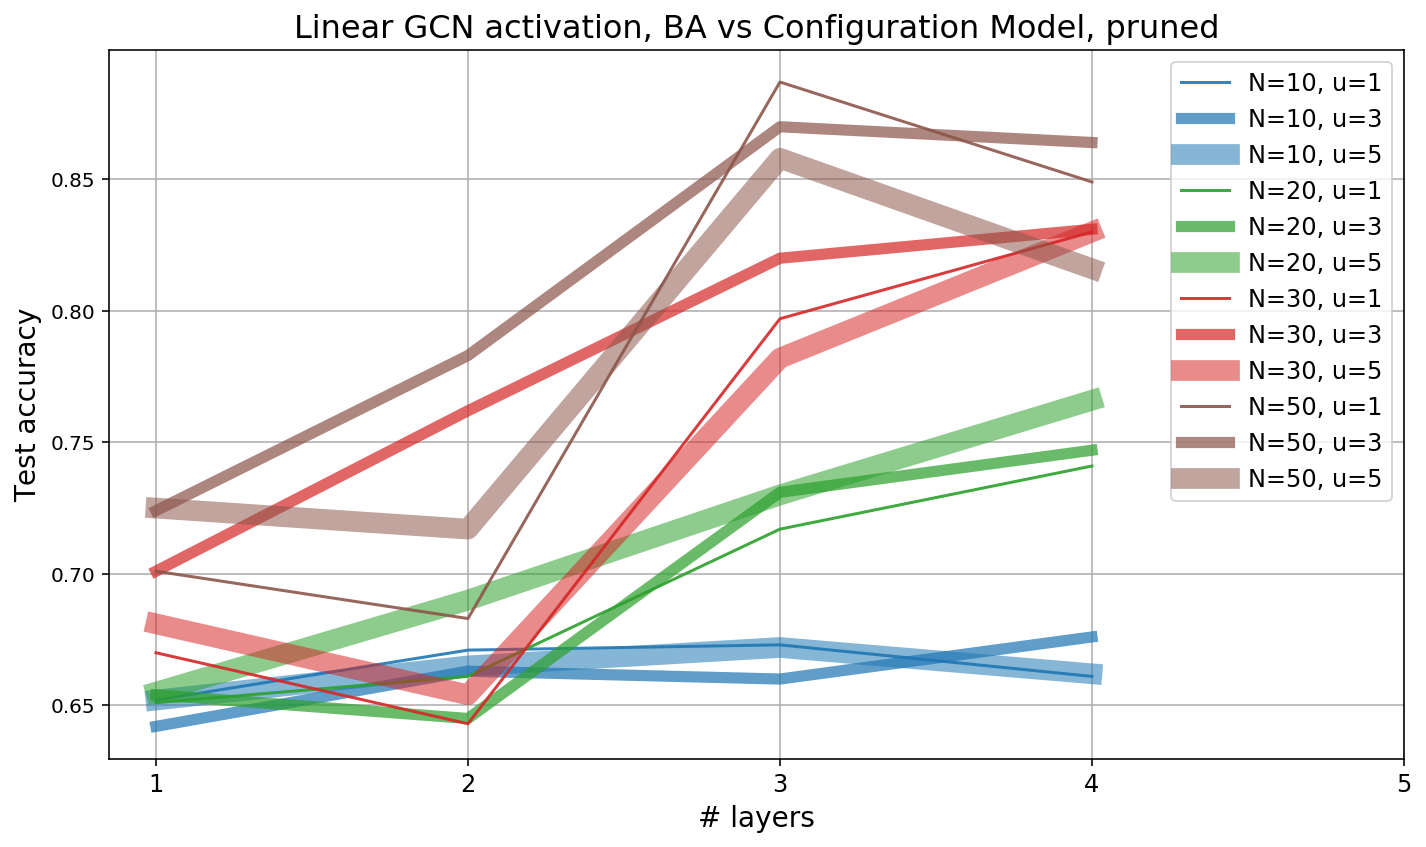

In [414]:
typ = pth.strip('/').split('/')[-1]
cols = dict(enumerate(mpl.colors.TABLEAU_COLORS))

# stl = ['-','--', ':']
figure(figsize=(10,6))
for ii,n in enumerate(n_list):
    if n==40:continue
    results = {}
    for r in res:
        if int(r.split('-N')[1].split('-')[0]) != n:
            continue
    #     print(r)
        g = pk.load(open(r, 'rb'))
        
        n_lay = len(g['params']['units'])
        act = g['params']['activation']
        results.setdefault(act, {})
        u = g['params']['units'][0]
        results[act][u] = results[act].get(u,[]) +[[n_lay,max(g['history']['val_acc'])]]


    for a in results:
        r1 = results[a]
        results[a] = {k: array(results[a][k])[argsort(array(results[a][k])[:,0])] for k in results[a]}
        
    for a in results:
        r1 = results[a]
        for i1,k in enumerate(sorted(r1)):
            plot(*r1[k][:-1].T, label = 'N=%d, u=%d' %(n,k), #ls= stl[i1],#marker = '.',
                 lw=1.5*k**1.2 , alpha= 1-tanh(k/10), c= cols[ii])
        t = ('%s vs Configuration Model' %typ.split('_')[0] if '_vs_' not in typ else typ.strip('_leaky_relu').replace('_', ' '))
        title('%s GCN activation, %s' %(a.capitalize(), t) + (', pruned' if '-trimmed' in res[0] else ''), size=16 )
        xlabel('# layers', size = 14)
        ylabel('Test accuracy', size = 14)
        xticks(arange(1,6),fontsize=12)
#         if ylim()[0] >0.95:
#             ylim(0.95,1.01)
#         ylim(0.75,1.01)
#         legend(ncol=5)

legend(fontsize= 12)
grid()

tight_layout()

nam = config_dir+'gcn-1-%s-All'%(typ) + ('-trimmed' if '-trimmed' in res[0] else '')
print(nam)

# savefig(nam +'.pdf')
# savefig(nam +'.png', dpi=300)
        
#         show()


../figs/expressivity/GCN/configuration_model//gcn-1-BA_leaky_relu-trimmed-architecture_vs_nodes-1


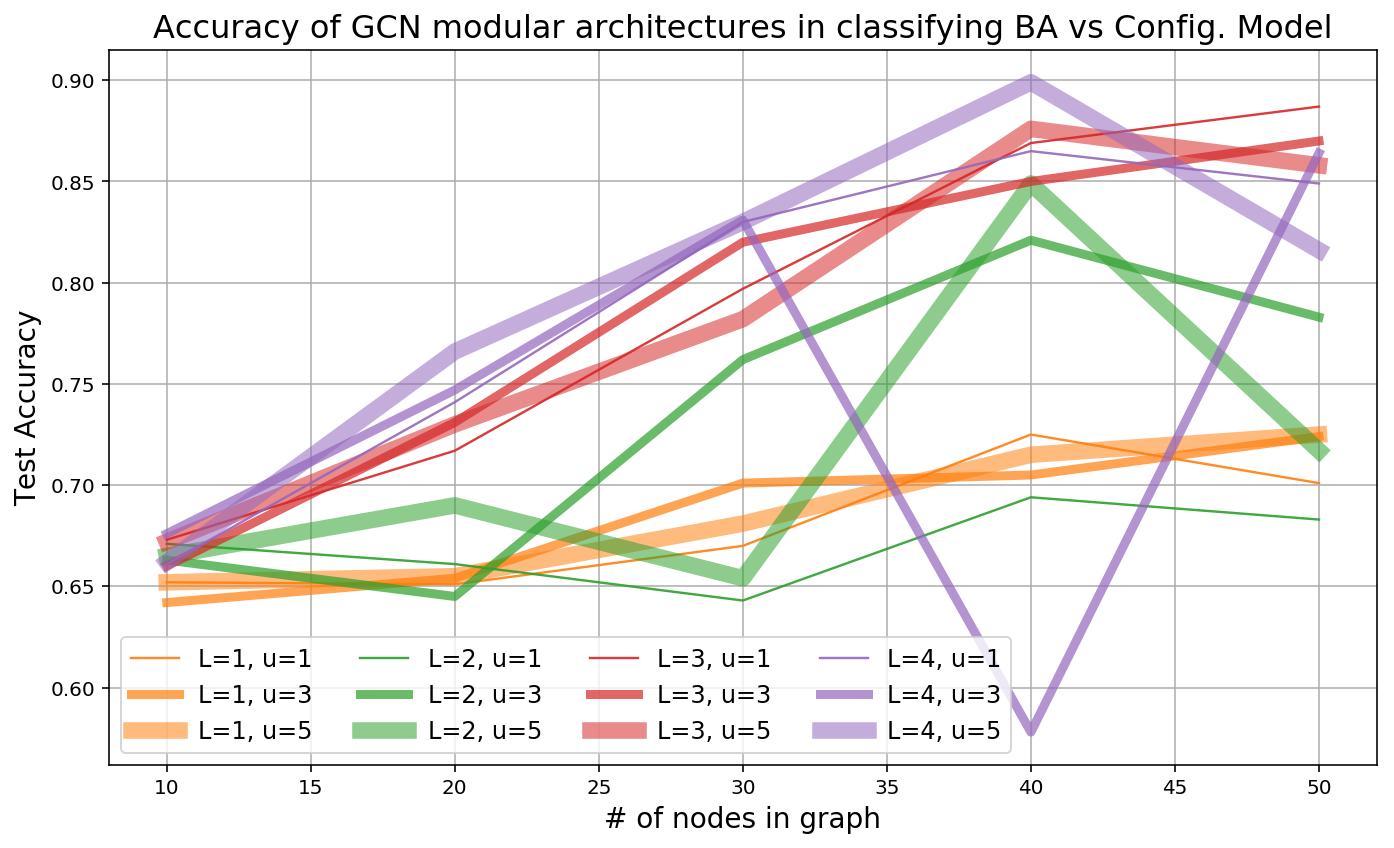

In [54]:
columns = {v:k for k,v in enumerate(['n','layers','units','val_acc','activation'])}
full_res = []
for r in res:
    g = pk.load(open(r, 'rb'))
    
    l = [None]*len(columns)
    l[columns['n']] = int(r.split('-N')[1].split('-')[0])
    l[columns['layers']] = len(g['params']['units'])
    l[columns['activation']] = g['params']['activation']
    results.setdefault(act, {})
    l[columns['units']] = g['params']['units'][0]
    l[columns['val_acc']] = max(g['history']['val_acc'])
# n = 40 shows strange fluctuations.... We omitted it from the final figure. Here you can see what 40 looked like. 
#     if l[columns['n']]== 40: 
#         print('skipping %s' %r) 
#         continue
    full_res += [l]
    
full_res = array(full_res)


s = set(full_res[:, columns['activation']])
results = {a: np.float32(full_res[where(full_res[:, columns['activation']]==a)[0], :-1]) for a in s}

r = results['linear']
stats = {}
for l in set(r[:,columns['layers']]):
    for u in set(r[:,columns['units']]):
        ix = where((r[:,columns['layers']]==l) * (r[:,columns['units']]==u))[0]
        k = (l,u)
        stats[k] = r[ix][:,[columns['n'],columns['val_acc']]]
        #stats[k] = stats.get(k, []) + [[r[columns['n']], r[columns['val_acc']]]]


# type of graphs
typ = pth.strip('/').split('/')[-1] 

cols = dict(enumerate(mpl.colors.TABLEAU_COLORS))

figure(figsize=(10,6))
for k in sorted(stats):
#     print(k)
    a = array(stats[k])
    l,u = k
    if l==5: continue
    plot(*a[argsort(a[:,0])].T, label = 'L=%d, u=%d' %k, lw=1.2*u**1.2 , alpha= 1-tanh(u/10), c = cols[l])

legend(ncol = 4,fontsize=12)
# ylim(.8,1.01)
xlabel('# of nodes in graph', size = 14)    
ylabel('Test Accuracy',size = 14)

t = ('%s vs Config. Model' %typ.split('_')[0] if '_vs_' not in typ else typ.strip('_leaky_relu').replace('_', ' '))
title('Accuracy of GCN modular architectures in classifying %s'%(t),size=16 )
nam = config_dir+'/gcn-1-%s-architecture_vs_nodes' %typ
# nam = config_dir+'/gcn-1-%s-architecture_vs_nodes-1' %typ
print(nam)
grid()
tight_layout()

savefig(nam +'.pdf')
savefig(nam +'.png', dpi=300)

# BA vs ER Classification results

In [61]:
pth = '../experiments/gcn_classification_grid_2_no_flatten/BA_vs_ER_leaky_relu/'
# pth = '../experiments/gcn_classification_grid_2_no_flatten/BA_leaky_relu-trimmed/'
# pth = '../experiments/gcn_classification_grid_2_no_flatten/BA_leaky_relu/'

res = glob(pth + '/gcn*.pkl')
# res = glob( '../experiments/gcn_classification_grid_2_no_flatten/BA_leaky_relu/gcn*.pkl')

len(res), res[0]

(75,
 '../experiments/gcn_classification_grid_2_no_flatten/BA_vs_ER_leaky_relu/gcn_model-N15-gcn[units[3]-activation_linear]-final[units_10]-skip1.pkl')

### Get list of node numbers

In [62]:
n_list = sorted(set(int(fname.split('-N')[1].split('-')[0]) for fname in res))
n_list

[10, 15, 20, 30, 50]

../figs/expressivity/GCN/configuration_model/gcn-1-BA_vs_ER_leaky_relu-All


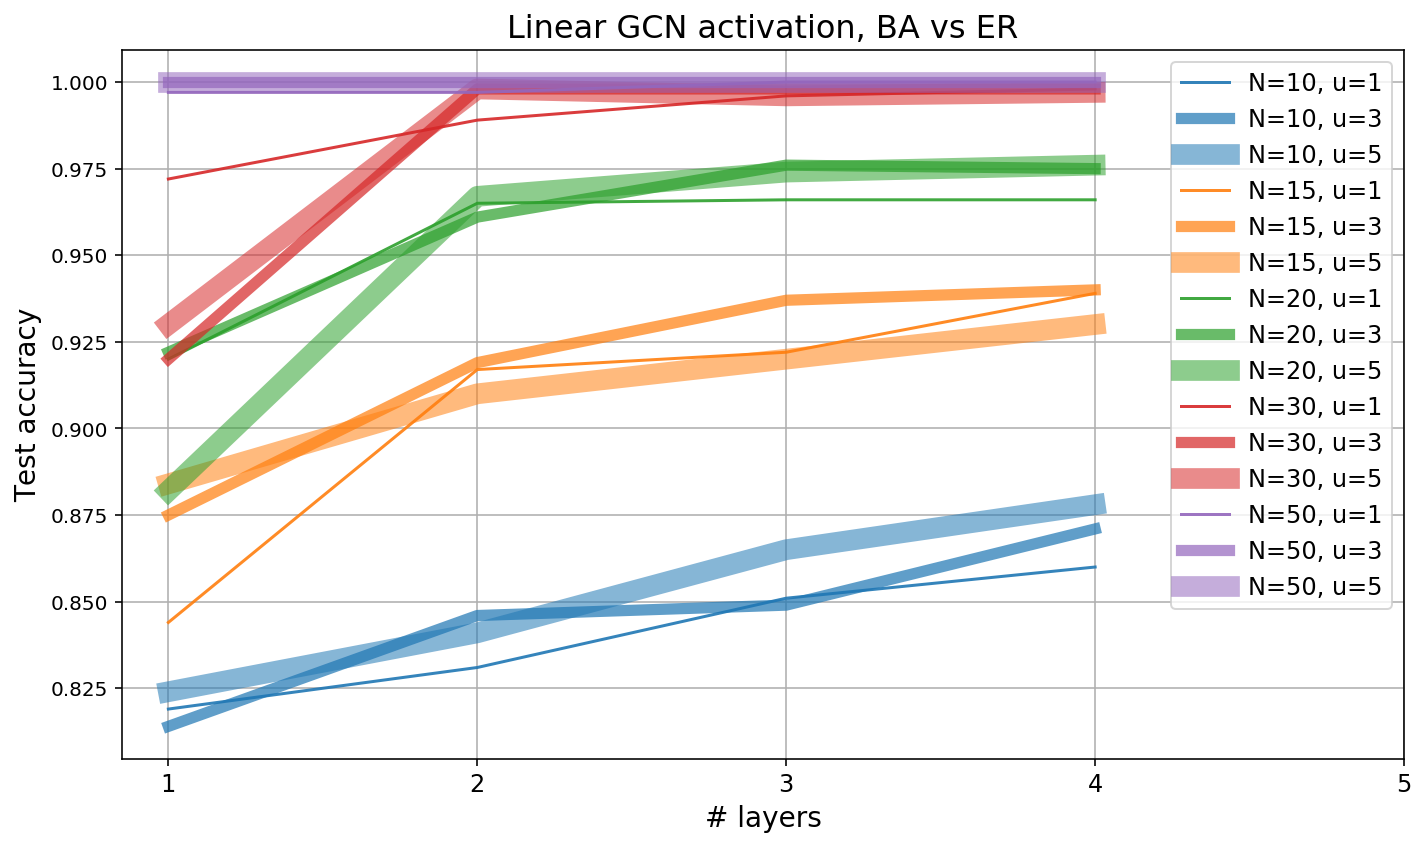

In [81]:
typ = pth.strip('/').split('/')[-1]
cols = dict(enumerate(mpl.colors.TABLEAU_COLORS))

# stl = ['-','--', ':']
figure(figsize=(10,6))
for ii,n in enumerate(n_list):
    results = {}
    for r in res:
        if int(r.split('-N')[1].split('-')[0]) != n:
            continue
    #     print(r)
        g = pk.load(open(r, 'rb'))
        n_lay = len(g['params']['units'])
        act = g['params']['activation']
        results.setdefault(act, {})
        u = g['params']['units'][0]
        results[act][u] = results[act].get(u,[]) +[[n_lay,max(g['history']['val_acc'])]]


    for a in results:
        r1 = results[a]
        results[a] = {k: array(results[a][k])[argsort(array(results[a][k])[:,0])] for k in results[a]}
        
    for a in results:
        r1 = results[a]
        for i1,k in enumerate(sorted(r1)):
            plot(*r1[k][:-1].T, label = 'N=%d, u=%d' %(n,k), #ls= stl[i1],#marker = '.',
                 lw=1.5*k**1.2 , alpha= 1-tanh(k/10), c= cols[ii])
        t = ('%s vs Configuration Model' %typ.split('_')[0] if '_vs_' not in typ else typ.strip('_leaky_relu').replace('_', ' '))
        title('%s GCN activation, %s' %(a.capitalize(), t) + (', pruned' if '-trimmed' in res[0] else ''), size=16 )
        xlabel('# layers', size = 14)
        ylabel('Test accuracy', size = 14)
        xticks(arange(1,6),fontsize=12)
#         if ylim()[0] >0.95:
#             ylim(0.95,1.01)
#         ylim(0.75,1.01)
#         legend(ncol=5)
        legend(fontsize= 12)
        grid()
        
        tight_layout()
        
nam = config_dir+'gcn-1-%s-All'%(typ) + ('-trimmed' if '-trimmed' in res[0] else '')
print(nam)
# savefig(nam +'.pdf')
# savefig(nam +'.png', dpi=300)
        
#         show()


../figs/expressivity/GCN/configuration_model//gcn-1-BA_vs_ER_leaky_relu-architecture_vs_nodes


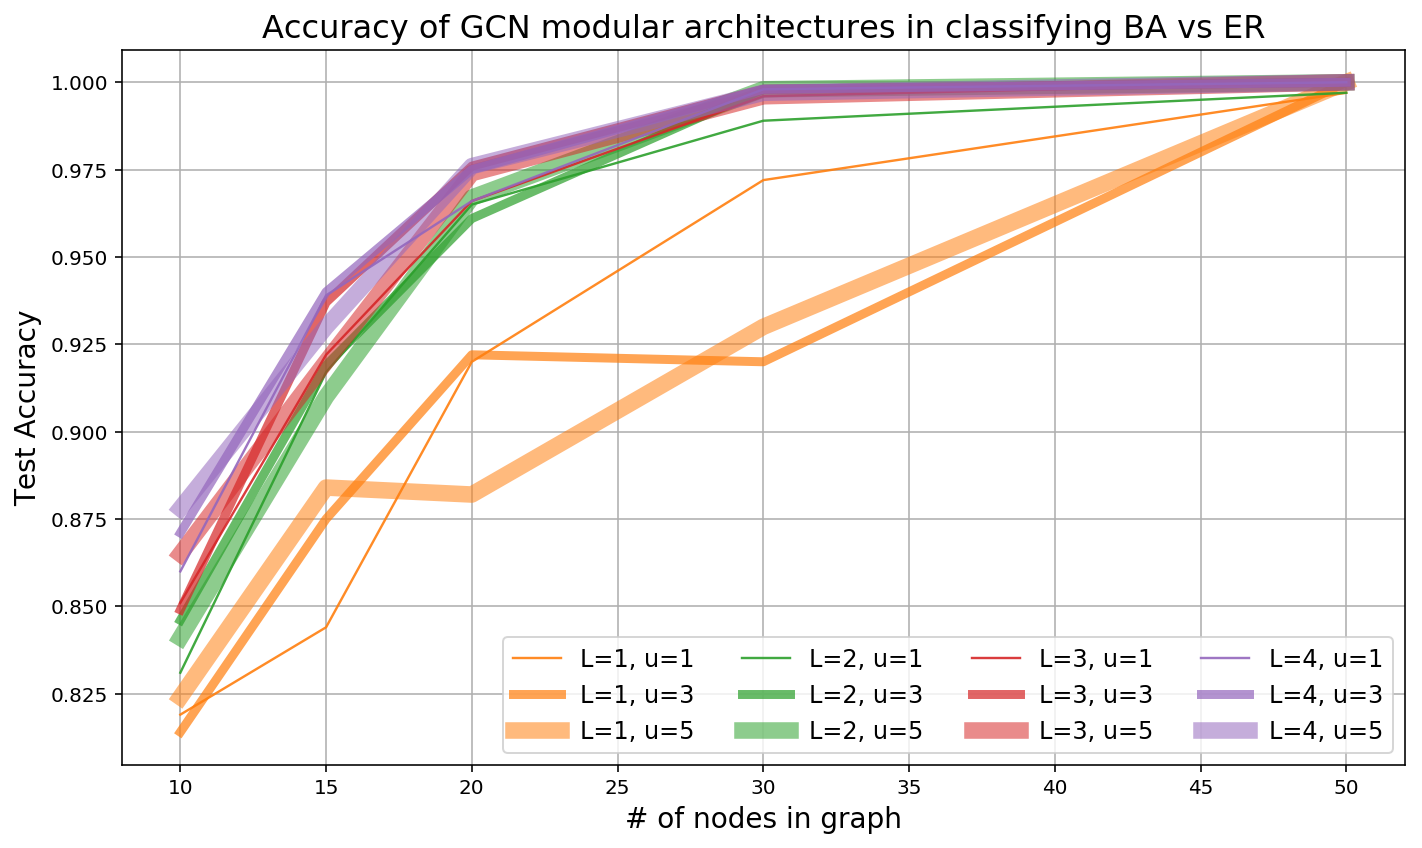

In [82]:
columns = {v:k for k,v in enumerate(['n','layers','units','val_acc','activation'])}
full_res = []
for r in res:
    g = pk.load(open(r, 'rb'))
    
    l = [None]*len(columns)
    l[columns['n']] = int(r.split('-N')[1].split('-')[0])
    l[columns['layers']] = len(g['params']['units'])
    l[columns['activation']] = g['params']['activation']
    results.setdefault(act, {})
    l[columns['units']] = g['params']['units'][0]
    l[columns['val_acc']] = max(g['history']['val_acc'])
# n = 40 shows strange fluctuations.... We omitted it from the final figure. Here you can see what 40 looked like. 
#     if l[columns['n']]== 40: 
#         print('skipping %s' %r) 
#         continue
    full_res += [l]
    
full_res = array(full_res)


s = set(full_res[:, columns['activation']])
results = {a: np.float32(full_res[where(full_res[:, columns['activation']]==a)[0], :-1]) for a in s}

r = results['linear']
stats = {}
for l in set(r[:,columns['layers']]):
    for u in set(r[:,columns['units']]):
        ix = where((r[:,columns['layers']]==l) * (r[:,columns['units']]==u))[0]
        k = (l,u)
        stats[k] = r[ix][:,[columns['n'],columns['val_acc']]]
        #stats[k] = stats.get(k, []) + [[r[columns['n']], r[columns['val_acc']]]]


# type of graphs
typ = pth.strip('/').split('/')[-1] 

cols = dict(enumerate(mpl.colors.TABLEAU_COLORS))

figure(figsize=(10,6))
for k in sorted(stats):
#     print(k)
    a = array(stats[k])
    l,u = k
    if l==5: continue
    plot(*a[argsort(a[:,0])].T, label = 'L=%d, u=%d' %k, lw=1.2*u**1.2 , alpha= 1-tanh(u/10), c = cols[l])

legend(ncol = 4,fontsize=12)
# ylim(.8,1.01)
xlabel('# of nodes in graph', size = 14)    
ylabel('Test Accuracy',size = 14)

t = ('%s vs Config. Model' %typ.split('_')[0] if '_vs_' not in typ else typ.strip('_leaky_relu').replace('_', ' '))
title('Accuracy of GCN modular architectures in classifying %s'%(t),size=16 )
nam = config_dir+'/gcn-1-%s-architecture_vs_nodes' %typ
# nam = config_dir+'/gcn-1-%s-architecture_vs_nodes-1' %typ
print(nam)
grid()
tight_layout()

# savefig(nam +'.pdf')
# savefig(nam +'.png', dpi=300)

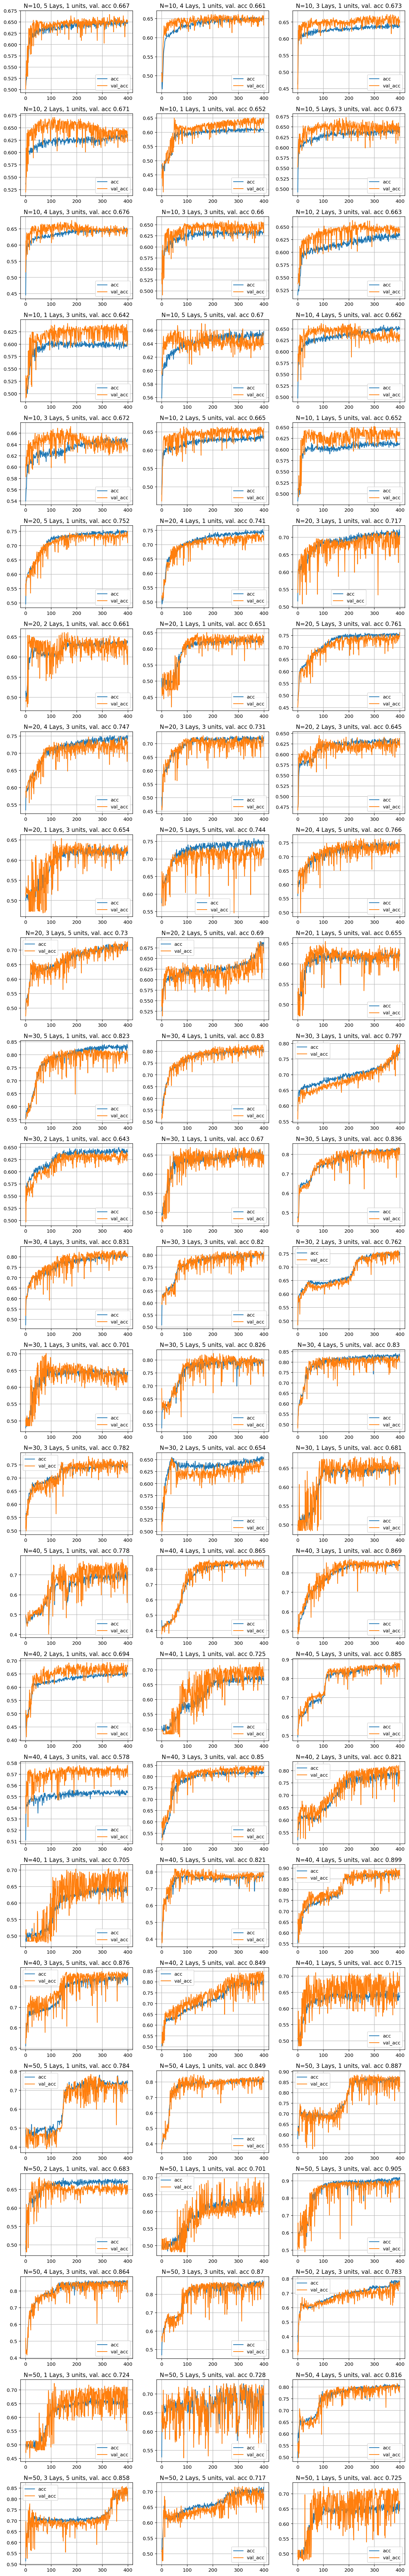

In [34]:
# n = 50
a = 3
num = round(len(res)/ a)

figure(figsize=(4*a, num*3))
i = 0
for r in sorted(res):
#     if int(r.split('-N')[1].split('-')[0]) != n:
#         continue
    n = int(r.split('-N')[1].split('-')[0])
    subplot(num,a,i+1)
    i+=1
    g = pk.load(open(r, 'rb'))
    n_lay = len(g['params']['units'])
    act = g['params']['activation']
    results.setdefault(act, {})
    u = g['params']['units'][0]
    for k in ['acc', 'val_acc']:
        plot(g['history'][k], label = k)

    legend()
    title('N=%d, %d Lays, %d units, val. acc %.3g' %(n,n_lay, u, max(g['history']['val_acc'])))
#     title(r.split('-N')[1].split('-activation')[0].strip('.pkl')+'\n max val %.3g' % max(g['history']['val_acc']) )
    grid()
    tight_layout()
    
show()

# Misc

In [39]:
# mkdir ../figs/expressivity/GCN/configuration_model/

In [259]:
typ = pth.strip('/').split('/')[-1]

config_dir = '../figs/expressivity/GCN/configuration_model/' 
# config_dir = '../figs/expressivity/GCN/%s/' %(typ.strip('_leaky_relu'))  
os.makedirs(config_dir, exist_ok=True)

figs_config = glob('../figs/expressivity/GCN/gcn-config*')
for f in figs_config:
    os.system('mv %s %s'%(f, config_dir))

config_dir


'../figs/expressivity/GCN/configuration_model/'

../figs/expressivity/GCN/BA_vs_ER/gcn-BA_vs_ER_leaky_relu-N10


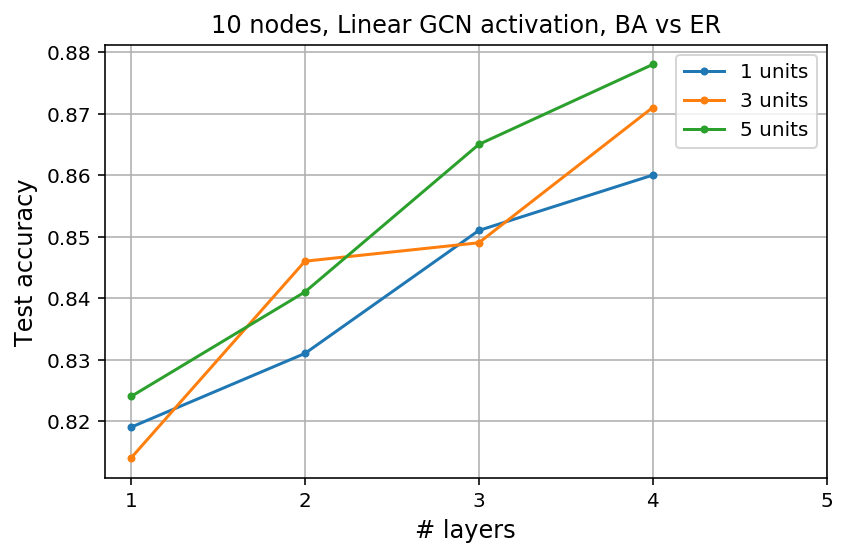

../figs/expressivity/GCN/BA_vs_ER/gcn-BA_vs_ER_leaky_relu-N15


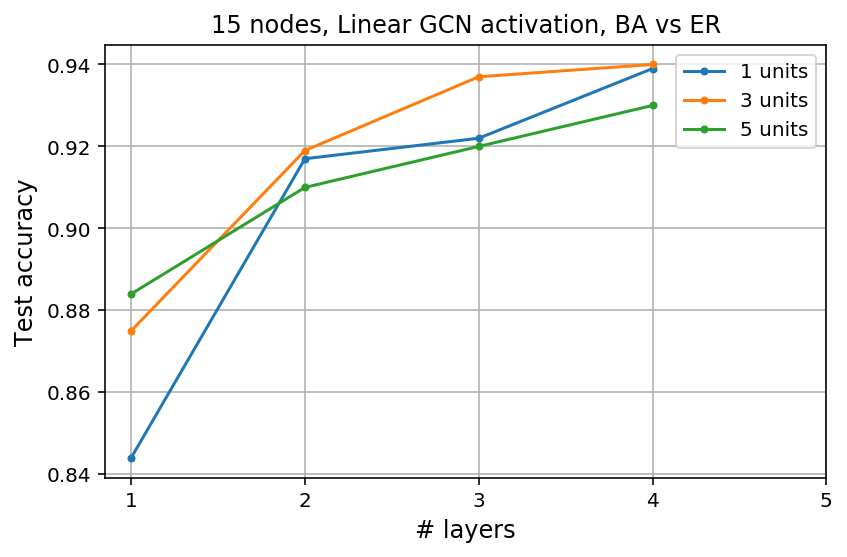

../figs/expressivity/GCN/BA_vs_ER/gcn-BA_vs_ER_leaky_relu-N20


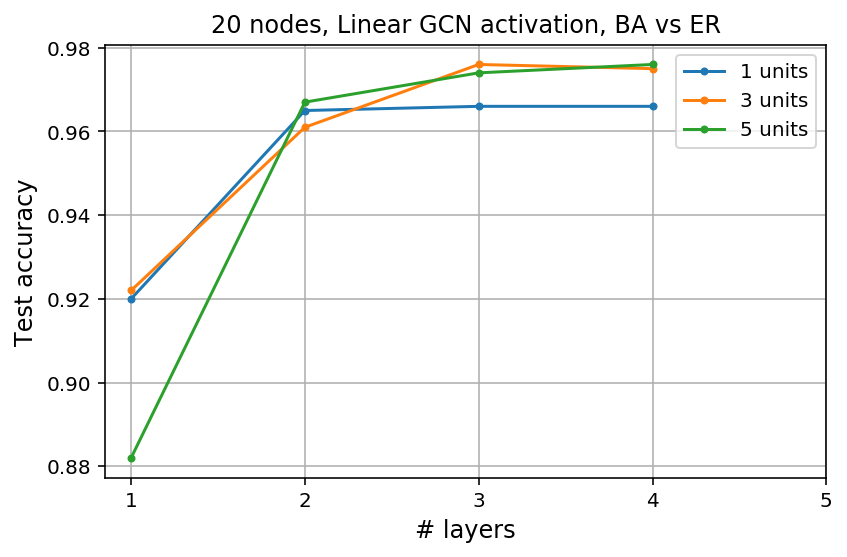

../figs/expressivity/GCN/BA_vs_ER/gcn-BA_vs_ER_leaky_relu-N30


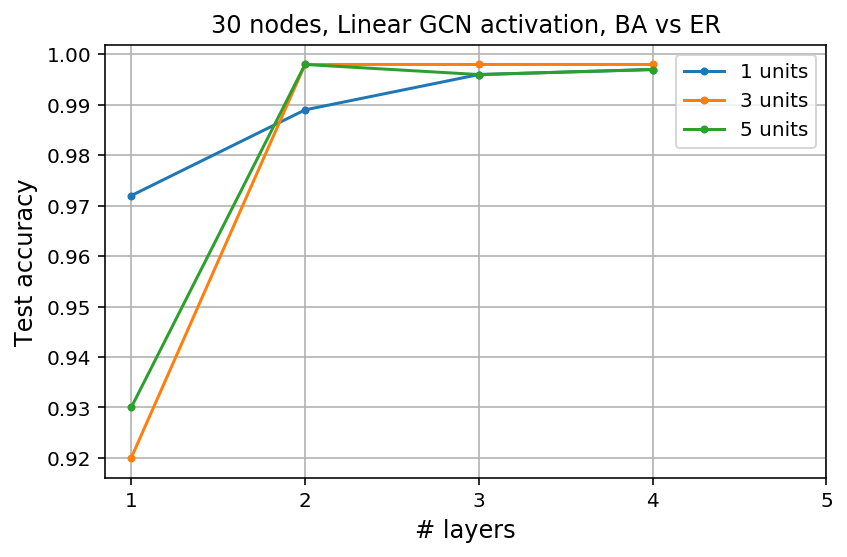

../figs/expressivity/GCN/BA_vs_ER/gcn-BA_vs_ER_leaky_relu-N50


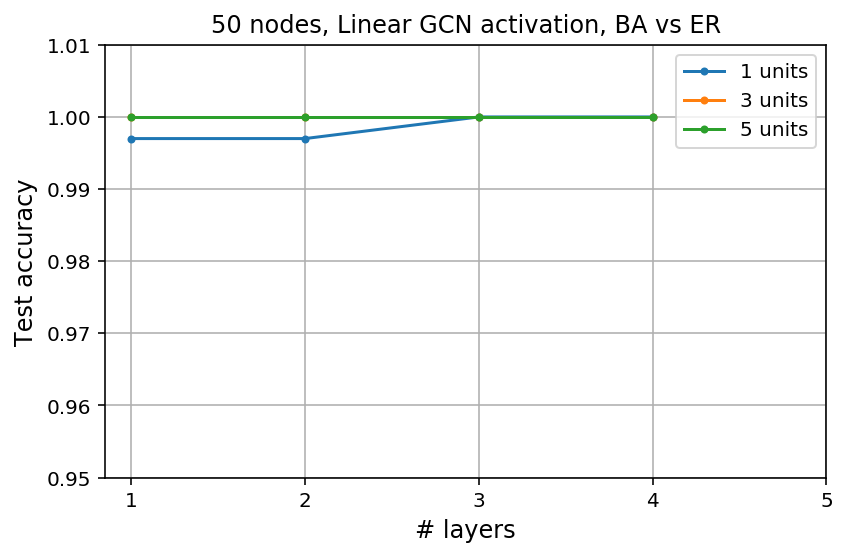

In [134]:
typ = pth.strip('/').split('/')[-1]

for n in n_list:
    results = {}

    for r in res:
        if int(r.split('-N')[1].split('-')[0]) != n:
            continue
    #     print(r)
        g = pk.load(open(r, 'rb'))
        n_lay = len(g['params']['units'])
        act = g['params']['activation']
        results.setdefault(act, {})
        u = g['params']['units'][0]
        results[act][u] = results[act].get(u,[]) +[[n_lay,max(g['history']['val_acc'])]]


    for a in results:
        r1 = results[a]
        results[a] = {k: array(results[a][k])[argsort(array(results[a][k])[:,0])] for k in results[a]}
        
    for a in results:
        r1 = results[a]
        for k in sorted(r1):
            plot(*r1[k][:-1].T, label = '%d units' %k, marker = '.')
        t = ('%s vs Configuration Model' %typ.split('_')[0] if '_vs_' not in typ else typ.strip('_leaky_relu').replace('_', ' '))
        title('%d nodes, %s GCN activation, %s' %(n,a.capitalize(), t) + (', pruned' if '-trimmed' in res[0] else '') )
        xlabel('# layers', size = 12)
        ylabel('Test accuracy', size = 12)
        xticks(arange(1,6))
        if ylim()[0] >0.95:
            ylim(0.95,1.01)
        legend()
        grid()
        
        tight_layout()
        nam = config_dir+'gcn-%s-N%d'%(typ,n) + ('-trimmed' if '-trimmed' in res[0] else '')
        print(nam)
        savefig(nam +'.pdf')
        savefig(nam +'.png', dpi=300)
        
        show()


../figs/expressivity/GCN/configuration_model/gcn-1-BA_leaky_relu-All


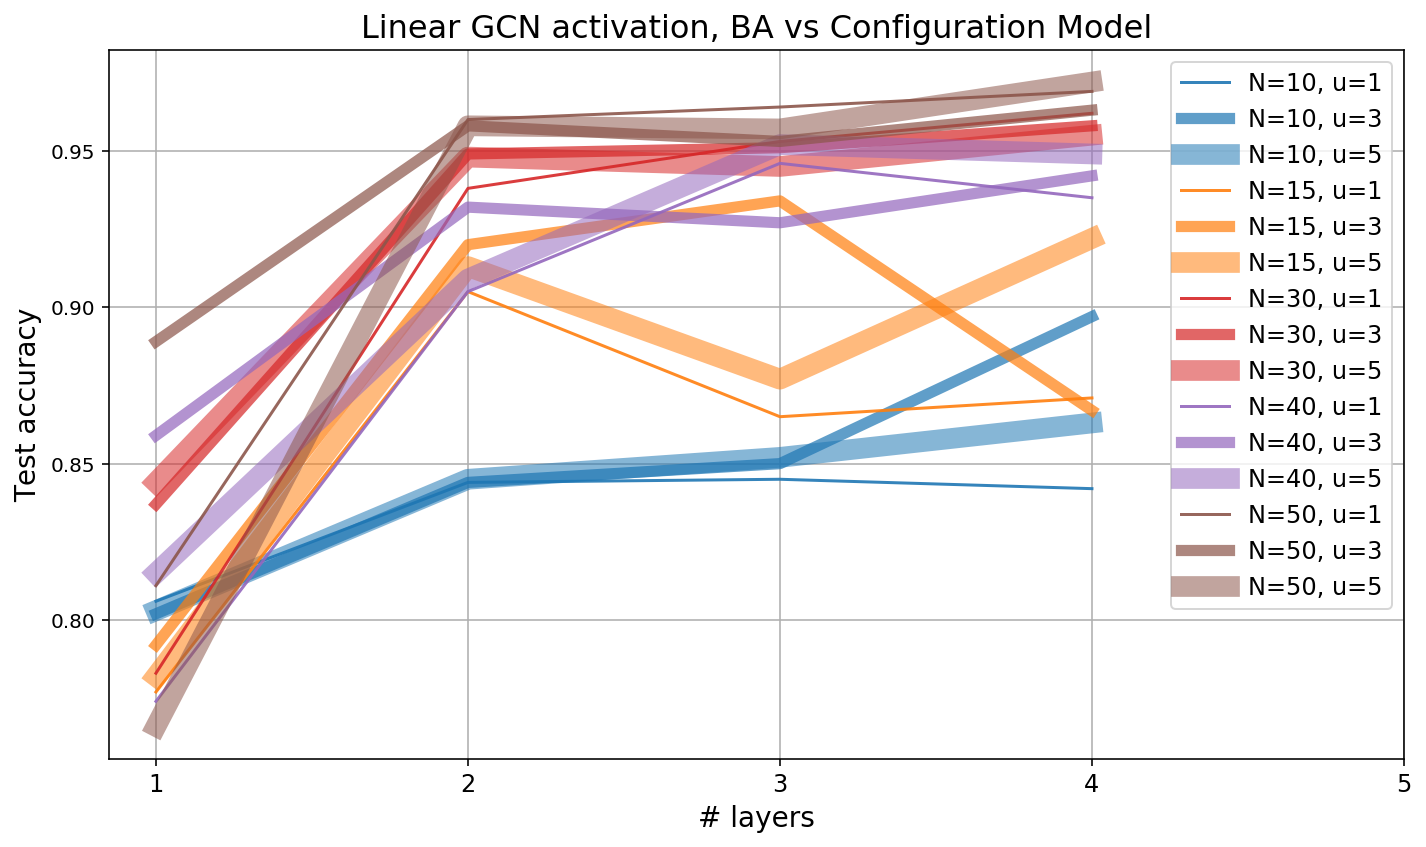

In [243]:
typ = pth.strip('/').split('/')[-1]
cols = dict(enumerate(mpl.colors.TABLEAU_COLORS))

# stl = ['-','--', ':']
figure(figsize=(10,6))
for ii,n in enumerate(n_list):
    if n==20 or n==60: continue
    results = {}
    for r in res:
        if int(r.split('-N')[1].split('-')[0]) != n:
            continue
    #     print(r)
        g = pk.load(open(r, 'rb'))
        n_lay = len(g['params']['units'])
        act = g['params']['activation']
        results.setdefault(act, {})
        u = g['params']['units'][0]
        results[act][u] = results[act].get(u,[]) +[[n_lay,max(g['history']['val_acc'])]]


    for a in results:
        r1 = results[a]
        results[a] = {k: array(results[a][k])[argsort(array(results[a][k])[:,0])] for k in results[a]}
        
    for a in results:
        r1 = results[a]
        for i1,k in enumerate(sorted(r1)):
            plot(*r1[k][:-1].T, label = 'N=%d, u=%d' %(n,k), #ls= stl[i1],#marker = '.',
                 lw=1.5*k**1.2 , alpha= 1-tanh(k/10), c= cols[ii])
        t = ('%s vs Configuration Model' %typ.split('_')[0] if '_vs_' not in typ else typ.strip('_leaky_relu').replace('_', ' '))
        title('%s GCN activation, %s' %(a.capitalize(), t) + (', pruned' if '-trimmed' in res[0] else ''), size=16 )
        xlabel('# layers', size = 14)
        ylabel('Test accuracy', size = 14)
        xticks(arange(1,6),fontsize=12)
#         if ylim()[0] >0.95:
#             ylim(0.95,1.01)
#         ylim(0.75,1.01)
#         legend(ncol=5)
        legend(fontsize= 12)
        grid()
        
        tight_layout()
        
nam = config_dir+'gcn-1-%s-All'%(typ) + ('-trimmed' if '-trimmed' in res[0] else '')
print(nam)
savefig(nam +'.pdf')
savefig(nam +'.png', dpi=300)
        
#         show()


../figs/expressivity/GCN/configuration_model/gcn-BA_leaky_relu-All


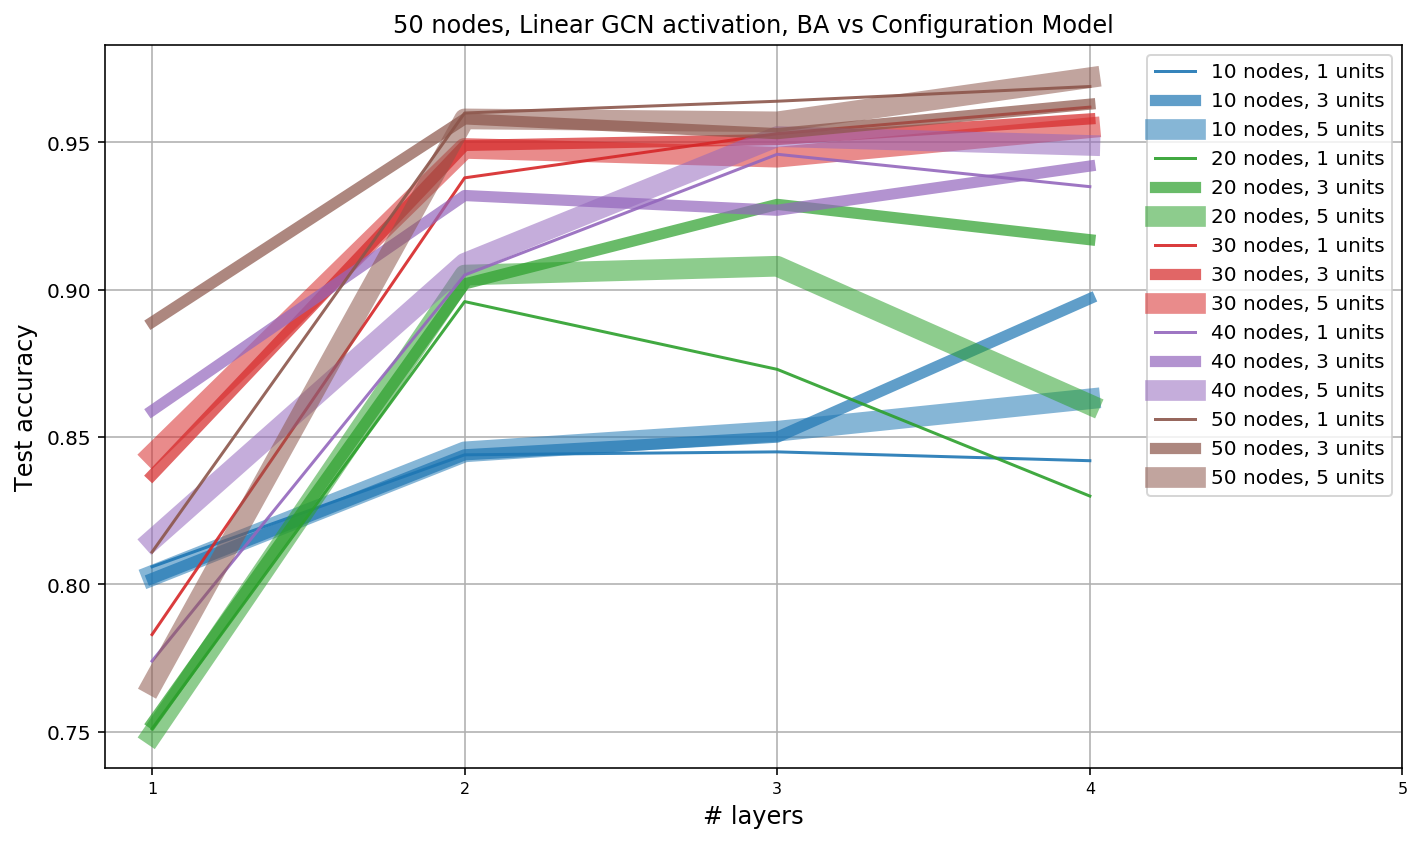

In [240]:
typ = pth.strip('/').split('/')[-1]
cols = dict(enumerate(mpl.colors.TABLEAU_COLORS))

# stl = ['-','--', ':']
figure(figsize=(10,6))
for ii,n in enumerate(n_list):
    if n==15 or n==60: continue
    results = {}
    for r in res:
        if int(r.split('-N')[1].split('-')[0]) != n:
            continue
    #     print(r)
        g = pk.load(open(r, 'rb'))
        n_lay = len(g['params']['units'])
        act = g['params']['activation']
        results.setdefault(act, {})
        u = g['params']['units'][0]
        results[act][u] = results[act].get(u,[]) +[[n_lay,max(g['history']['val_acc'])]]


    for a in results:
        r1 = results[a]
        results[a] = {k: array(results[a][k])[argsort(array(results[a][k])[:,0])] for k in results[a]}
        
    for a in results:
        r1 = results[a]
        for i1,k in enumerate(sorted(r1)):
            plot(*r1[k][:-1].T, label = '%d nodes, %d units' %(n,k), #ls= stl[i1],#marker = '.',
                 lw=1.5*k**1.2 , alpha= 1-tanh(k/10), c= cols[ii])
        t = ('%s vs Configuration Model' %typ.split('_')[0] if '_vs_' not in typ else typ.strip('_leaky_relu').replace('_', ' '))
        title('%d nodes, %s GCN activation, %s' %(n,a.capitalize(), t) + (', pruned' if '-trimmed' in res[0] else '') )
        xlabel('# layers', size = 12)
        ylabel('Test accuracy', size = 12)
        xticks(arange(1,6),fontsize=8)
        if ylim()[0] >0.95:
            ylim(0.95,1.01)
        legend()
        grid()
        
        tight_layout()
        
nam = config_dir+'gcn-%s-All'%(typ) + ('-trimmed' if '-trimmed' in res[0] else '')
print(nam)
savefig(nam +'.pdf')
savefig(nam +'.png', dpi=300)
        
#         show()


# plot single arch performance for various num nodes

In [232]:
columns = {v:k for k,v in enumerate(['n','layers','units','val_acc','activation'])}
full_res = []
for r in res:
    g = pk.load(open(r, 'rb'))
    
    l = [None]*len(columns)
    l[columns['n']] = int(r.split('-N')[1].split('-')[0])
    l[columns['layers']] = len(g['params']['units'])
    l[columns['activation']] = g['params']['activation']
    results.setdefault(act, {})
    l[columns['units']] = g['params']['units'][0]
    l[columns['val_acc']] = max(g['history']['val_acc'])
#     if l[columns['n']]== 20: 
#         print('hi')
#         continue
    full_res += [l]
    
full_res = array(full_res)

In [233]:
s = set(full_res[:, columns['activation']])
results = {a: np.float32(full_res[where(full_res[:, columns['activation']]==a)[0], :-1]) for a in s}

r = results['linear']
stats = {}
for l in set(r[:,columns['layers']]):
    for u in set(r[:,columns['units']]):
        ix = where((r[:,columns['layers']]==l) * (r[:,columns['units']]==u))[0]
        k = (l,u)
        stats[k] = r[ix][:,[columns['n'],columns['val_acc']]]
        #stats[k] = stats.get(k, []) + [[r[columns['n']], r[columns['val_acc']]]]


In [234]:
# full_res

../figs/expressivity/GCN/configuration_model//gcn-1-BA_leaky_relu-architecture_vs_nodes


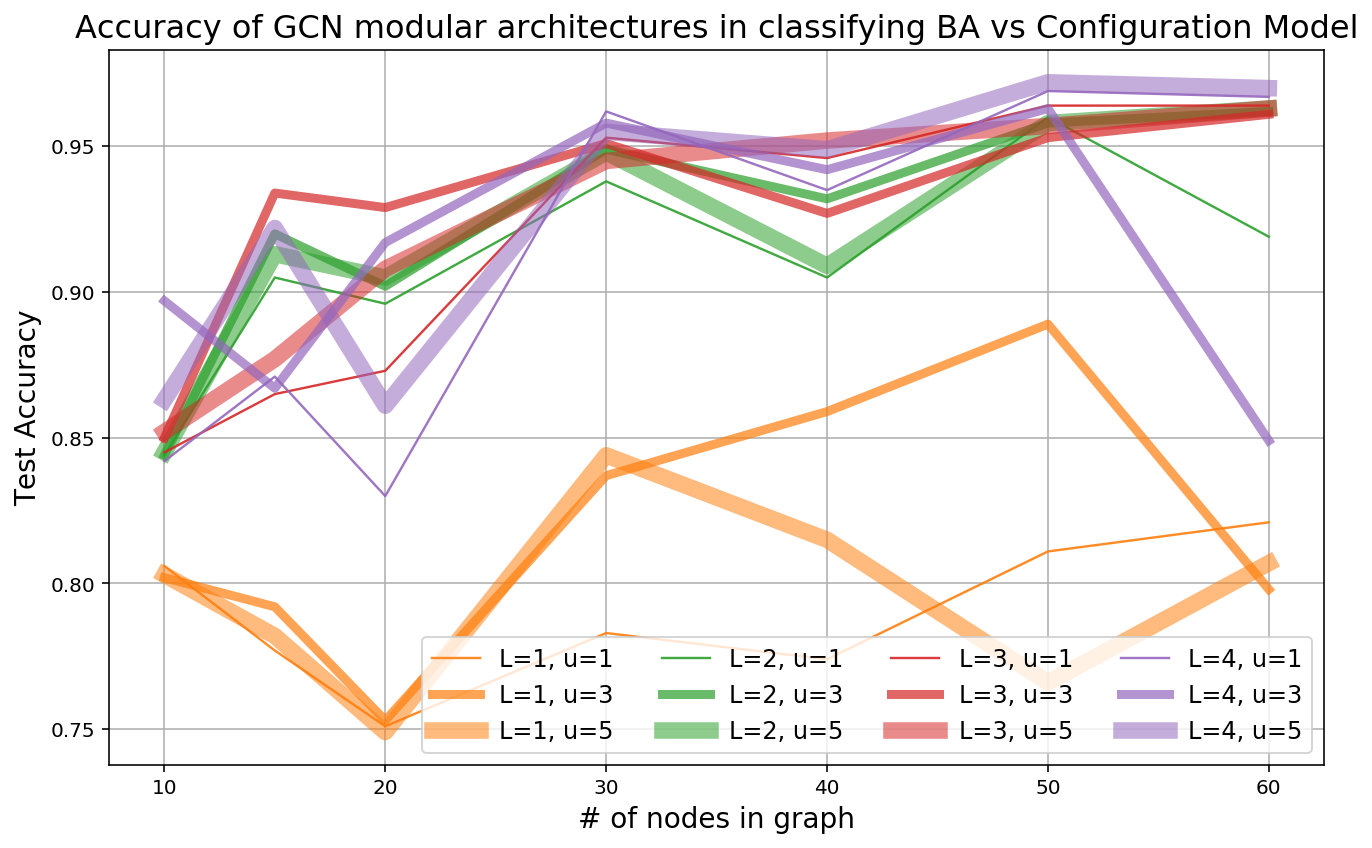

In [244]:
# type of graphs
typ = pth.strip('/').split('/')[-1] 

cols = dict(enumerate(mpl.colors.TABLEAU_COLORS))

figure(figsize=(10,6))
for k in sorted(stats):
#     print(k)
    a = array(stats[k])
    l,u = k
    if l==5: continue
    plot(*a[argsort(a[:,0])].T, label = 'L=%d, u=%d' %k, lw=1.2*u**1.2 , alpha= 1-tanh(u/10), c = cols[l])

legend(ncol = 4,fontsize=12)
# ylim(.8,1.01)
xlabel('# of nodes in graph', size = 14)    
ylabel('Test Accuracy',size = 14)

t = ('%s vs Configuration Model' %typ.split('_')[0] if '_vs_' not in typ else typ.strip('_leaky_relu').replace('_', ' '))
title('Accuracy of GCN modular architectures in classifying %s'%(t),size=16 )
nam = config_dir+'/gcn-1-%s-architecture_vs_nodes' %typ
print(nam)
grid()
tight_layout()

savefig(nam +'.pdf')
savefig(nam +'.png', dpi=300)

# Example of the GCN used for classification
To do the final classification, we perform a mean pooling of the final output, which is a concatenation of outputs of all GCN modules. 

In [183]:
lays = 3
units = 2
units_final = 5

params = {'units': [units]*lays , 'activation': 'linear','skip':True, 
          'final_kws': {'units': units_final,'activation': 'linear'}, }
    
Adjacencies = data_config
h = np.ones(Adjacencies.shape[:2]+(1,))
labels = to_categorical(labels_config)

indices = idx

# import GraphConvNet as gcn

gcn_model = gcn.MultiGCN(input_shape= h[0].shape, **params)
    
# use leaky ReLU on the last layer
ac = gcn.layers.LeakyReLU(alpha = 0.3)(gcn_model.model.output)
# classification_layer = gcn.Dense(len(labels[0]), activation='softmax')( gcn.layers.Flatten()( ac ) )
# classification_layer = gcn.Dense(len(labels[0]), activation='softmax')( gcn.layers.Flatten()( gcn_model.model.output ) )

den1 = gcn.Dense(len(labels[0]), activation='softmax')( ac ) # has dims N x out channels must sum over N
# make layer to average over nodes
Avg_Nodes = gcn.layers.Lambda(lambda x: gcn.K.mean(x,axis = 1))
classification_layer = Avg_Nodes(den1)

model = gcn.Model(inputs = gcn_model.model.inputs, outputs = [classification_layer] )
model.compile(optimizer='adam', loss = 'categorical_crossentropy' ,metrics=['accuracy'])

model.summary()

# gcn_model.history = gcn.EpochHistory(metrics=['acc','val_acc']) 
# gcn_model.model = model

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 50, 50)       0                                            
__________________________________________________________________________________________________
graph__operators_2 (Graph_Opera [(None, 50, 50), (No 0           input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 50, 1)        0                                            
__________________________________________________________________________________________________
A_0 (GCN)                       (None, 50, 2)        4           graph__operators_2[0][0]         
                                                                 input_4[0][0]                    
__________